Importación de librerias

In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

import torch
from pytorch_tabnet.tab_model import TabNetClassifier

import warnings
warnings.filterwarnings('ignore')

Ajustamos el número de muestras (El máximo del dataset es 100.000)

In [2]:
N_Samples = 50000

Carga del dataset

In [3]:
try:
    data = pd.read_csv(f'../Datasets/dataset_original.csv')
except FileNotFoundError:
    print("Error: No se encontró el archivo 'dataset_original.csv'.")
    exit()

Codificar las features categoricas

In [4]:
target_column = 'diabetes'
categorical_features = ['gender', 'smoking_history']
numerical_features = [col for col in data.columns if col not in categorical_features + [target_column]]
# Codificar las características categóricas
label_encoders_X = {}
for col in categorical_features:
    le = LabelEncoder()
    data[col] = data[col].astype(str)
    data[col] = le.fit_transform(data[col])
    label_encoders_X[col] = le

Ajustar el número de muestras con la misma proporción entre clases

In [5]:
min_class_count = data['diabetes'].value_counts().min()
if N_Samples > len(data) or int(N_Samples * data['diabetes'].value_counts(normalize=True).min()) > min_class_count:
     print(f"Advertencia: El tamaño de muestra es muy grande. Se usará el dataset completo.")
     data = data.copy()
else:
    proportions = data['diabetes'].value_counts(normalize=True)
    data = data.groupby('diabetes', group_keys=False).apply(
        lambda x: x.sample(int(N_Samples * proportions[x.name]), random_state=42)
    )

print(f"Cantidad de datos a considerar: {len(data)}")
print("\nProporción de clases en el nuevo dataset:")
print(data['diabetes'].value_counts(normalize=True))

Cantidad de datos a considerar: 50000

Proporción de clases en el nuevo dataset:
diabetes
0    0.915
1    0.085
Name: proportion, dtype: float64


División conjunto de entrenamiento y test, escalado de los datos númericos:

In [6]:
data[target_column] = data[target_column].astype(int)

X = data.drop(columns=[target_column])
y = data[target_column]

# Se usa un 80% para entrenamiento y un 20% para test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Escalado de las características numéricas
scaler = StandardScaler()
X_train.loc[:, numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test.loc[:, numerical_features] = scaler.transform(X_test[numerical_features])

X_train_np = X_train.values
y_train_np = y_train.values
X_test_np = X_test.values
y_test_np = y_test.values

## Saltar esta celda en caso de querer usar el modelo guardado -->

Preparación de parametros, inicialización y entrenamiento del modelo

In [7]:
# Requisisto para TabNet: Busca los índices y dimensiones de las características categóricas
cat_idxs = [X.columns.get_loc(col) for col in categorical_features]
# Requisito para TabNet: Calcula cuántas categorías únicas hay en cada columna categórica
cat_dims = [len(le.classes_) for le in label_encoders_X.values()]

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
weighted_loss_fn = torch.nn.CrossEntropyLoss() # Función de pérdida

# Inicialización del modelo TabNetClassifier
clf = TabNetClassifier(
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    optimizer_params=dict(lr=1e-3), # Ajuste del learning rate
    optimizer_fn=torch.optim.Adam, # Se usa el optimizador Adam
    verbose=1,
    seed=42
)

# Entrenamiento del modelo TabNetClassifier
print(f"\n Iniciando Entrenamiento de TabNet:{' ' + DEVICE.upper()}")
clf.fit(
    X_train=X_train_np, y_train=y_train_np,
    eval_set=[(X_test_np, y_test_np)],
    patience=10, # Early stopping después de 10 epoch sin mejora
    max_epochs=100,
    eval_metric=['accuracy', 'logloss'], # Métricas de evaluación
    loss_fn=weighted_loss_fn, # Función de pérdida
    batch_size=256 # Número de muestras por cada paso de entrenamiento
)


 Iniciando Entrenamiento de TabNet: CPU
epoch 0  | loss: 0.51578 | val_0_accuracy: 0.9366  | val_0_logloss: 0.21225 |  0:00:03s
epoch 1  | loss: 0.18205 | val_0_accuracy: 0.9475  | val_0_logloss: 0.15567 |  0:00:06s
epoch 2  | loss: 0.14787 | val_0_accuracy: 0.9528  | val_0_logloss: 0.13863 |  0:00:08s
epoch 3  | loss: 0.13472 | val_0_accuracy: 0.9565  | val_0_logloss: 0.12929 |  0:00:11s
epoch 4  | loss: 0.13026 | val_0_accuracy: 0.9587  | val_0_logloss: 0.12454 |  0:00:14s
epoch 5  | loss: 0.12449 | val_0_accuracy: 0.959   | val_0_logloss: 0.1194  |  0:00:17s
epoch 6  | loss: 0.12023 | val_0_accuracy: 0.9602  | val_0_logloss: 0.1181  |  0:00:20s
epoch 7  | loss: 0.11875 | val_0_accuracy: 0.9607  | val_0_logloss: 0.11579 |  0:00:23s
epoch 8  | loss: 0.11561 | val_0_accuracy: 0.9617  | val_0_logloss: 0.11475 |  0:00:26s
epoch 9  | loss: 0.11382 | val_0_accuracy: 0.9605  | val_0_logloss: 0.11288 |  0:00:28s
epoch 10 | loss: 0.11074 | val_0_accuracy: 0.964   | val_0_logloss: 0.10734 |  

Se guarda el modelo en un .zip

In [8]:
directorio = os.getcwd()
carpeta = "../Guardar_modelo/TabNet"
archivo_xgb = f'Binary_TabNet_{N_Samples}'

ruta = os.path.join(directorio, carpeta, archivo_xgb)

directorio_final_para_guardar = os.path.dirname(ruta)
os.makedirs(directorio_final_para_guardar, exist_ok=True)

clf.save_model(ruta)

Successfully saved model at c:\Users\tcidm\OneDrive\Escritorio\Material U\DeepLearning\ProyectoDeepLearning\Modelo_TabNet\../Guardar_modelo/TabNet\Binary_TabNet_50000.zip


'c:\\Users\\tcidm\\OneDrive\\Escritorio\\Material U\\DeepLearning\\ProyectoDeepLearning\\Modelo_TabNet\\../Guardar_modelo/TabNet\\Binary_TabNet_50000.zip'

Se puede cargar el modelo descomentando las primeras líneas


--- Resultados de la Evaluación Final ---
Precisión (Accuracy) en el conjunto de prueba: 0.9700

Reporte de Clasificación:
              precision    recall  f1-score   support

 No Diabetes       0.97      1.00      0.98      9150
    Diabetes       0.99      0.65      0.79       850

    accuracy                           0.97     10000
   macro avg       0.98      0.83      0.89     10000
weighted avg       0.97      0.97      0.97     10000


Matriz de Confusión:


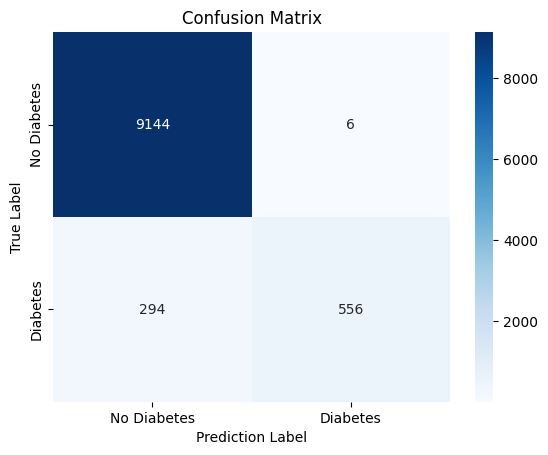


Curva de Pérdida del Entrenamiento:


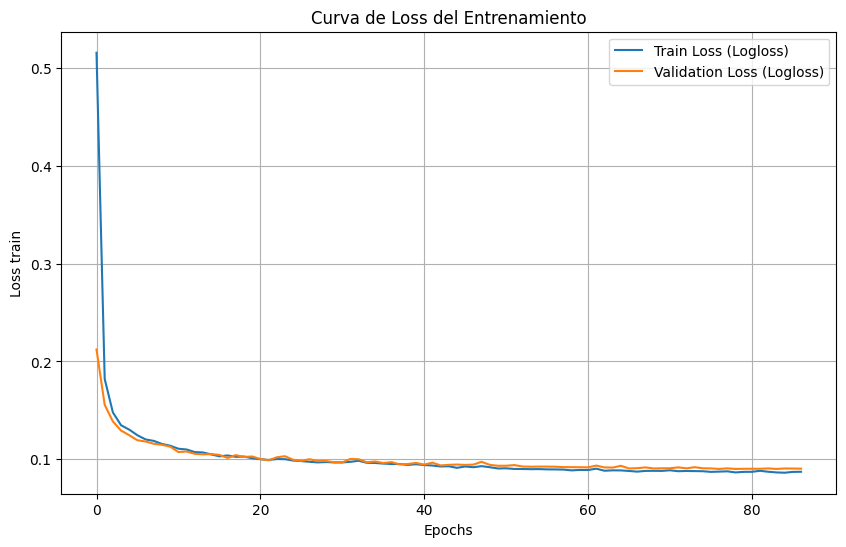

In [9]:
#Carga del modelo guardado
#preTrained = TabNetClassifier()
#preTrained.load_model(ruta)

y_pred = clf.predict(X_test_np) #Cambiar cfl por preTrained si se usa el modelo guardado
test_accuracy = accuracy_score(y_test_np, y_pred)

print("\n--- Resultados de la Evaluación Final ---")
print(f"Precisión (Accuracy) en el conjunto de prueba: {test_accuracy:.4f}")

print("\nReporte de Clasificación:")
print(classification_report(y_test_np, y_pred, target_names=['No Diabetes', 'Diabetes']))

print("\nMatriz de Confusión:")
cm = confusion_matrix(y_test_np, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Diabetes', 'Diabetes'], yticklabels=['No Diabetes', 'Diabetes'])
plt.xlabel('Prediction Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("\nCurva de Pérdida del Entrenamiento:")
train_loss = clf.history['loss']
val_loss = clf.history['val_0_logloss']
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Train Loss (Logloss)')
plt.plot(val_loss, label='Validation Loss (Logloss)')
plt.title('Curva de Loss del Entrenamiento')
plt.xlabel('Epochs')
plt.ylabel('Loss train')
plt.legend()
plt.grid(True)
plt.show()